<a href="https://colab.research.google.com/github/martinpius/Work-out-with-Matplotlib/blob/master/Survival_Modeling_NNT_Predictions_using_The_CPH_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount("/content/drive", force_remount = True)
try:
  COLAB = True
  import tensorflow as tf
  print(f"You are using Colab with tensoflow version: {tf.__version__}")
except Exception as e:
  COLAB = False
  print(f"{type(e)}: {e}\n...Please Load Your Drive...")

def time_fmt(t):
  h = int(t / (60 * 60))
  m = int(t % (60 * 60) / 60)
  s = int(t % 60)
  return f"{h}: {m:>03}: {s:>05.2f}"
print(f"test time: {time_fmt(128.1987)}")

Mounted at /content/drive
You are using Colab with tensoflow version: 2.4.1
test time: 0: 002: 08.00


In [5]:
!pip install scikit-survival

     |████████████████████████████████| 2.3MB 10.5MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for scikit-survival: filename=scikit_survival-0.14.0-cp36-cp36m-linux_x86_64.whl size=4056517 sha256=66090b61fda883ecf34a6c1cea3f973613892bef1e8e179e1ac553ad6768945c
  Stored in directory: /root/.cache/pip/wheels/f4/af/94/be84d2dc68a947ad2859b1608f1d57a4328465a0b00b0fb4ac
Successfully built scikit-survival


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from typing import Tuple, Dict, Any, Iterable, Union, Optional
from pathlib import Path
from sksurv.nonparametric import kaplan_meier_estimator
from sklearn.model_selection import train_test_split
from sksurv.metrics import concordance_index_censored


In [7]:
#Simulation survival data based on mnist images:
#We will obtain survival time as random survival scores coresponding to each digits
#We will first create the class labels for each digit (0, 1, ..., 9)
#Classes will be randomly assigned to four risk groups (0,1,2,3) which discriminate the individual
 

In [8]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [9]:
#standerdize the data and convert the labels to int:

In [10]:
x_train, x_test = x_train.astype('float32')/255.0 , x_test.astype('float32')/255.0

In [11]:
y_train, y_test = y_train.astype('int32'), y_test.astype('int32')

In [12]:
y = np.concatenate((y_train, y_test)) #Combine the labels

In [13]:
#Write a function to create a synthetic survival data based on the labels of mnist data:
def create_survival_data(y: np.ndarray,n_groups: int = 4,seed: int = 10)->Tuple[pd.DataFrame, np.array]:
  '''This function will create random risk scores for each class label based on 4 random risk groups'''
  rnd = np.random.RandomState(seed = seed)

  #Assign class labels (0, 1 2 ..., 9) to risk groups (0,1,2,3):
  classes = np.unique(y) #obtain the unique values for the class variable (the labels)
  grp_assigment = {} #Place holder for the label-group mapping 
  grp_members = {}#place holder for risk groups
  groups = rnd.randint(n_groups, size = classes.shape) #First we random Create risk groups (0,1,2,3)
  #Assign classes to risk groups (we assign at random classes 0, 1, ...9) to risk groups (0,1,2,3):
  for label, group in zip(classes, groups):
    grp_assigment[label] = group
    grp_members.setdefault(group, []).append(label) #append (the labels that falls on same group) to a unique group

  #Create the corresponding risk score for each class label (0, 1,..., 8, 9)
  risk_per_class = {}
  for label in classes:
    grp_index = grp_assigment[label]
    group = grp_members[grp_index]
    label_index = group.index(label)
    group_size = len(group)
    risk_score = np.sqrt(grp_index + 1e-4)*1.75 #Computing the risk score (You can use any formulation)
    risk_score-=(label_index - (group_size)//2)/25. #allow the slight variation accross the group-scores
    risk_per_class[label] = risk_score #create the risk score corresponding to each label (0, 1 2,..., 8,9)
  
  assignment = pd.concat((pd.Series(risk_per_class, name = 'risk_per_class'),
                          pd.Series(grp_assigment, name = 'risk_groups')),axis = 1).rename_axis('class_label')
  risk_scores = np.array([risk_per_class[yy] for yy in y])
  return assignment, risk_scores


In [14]:
#Create the data by passing the mnist labels:
assignment, risk_scores = create_survival_data(y)

In [15]:
assignment.round(4)

,risk_per_class,risk_groups
class_label,,
0,1.8301,1
1,1.7901,1
2,0.0575,0
3,3.0711,3
4,0.0175,0
5,1.7501,1
6,3.0311,3
7,-0.0225,0
8,1.7101,1


In [16]:
#We can see that class labels 3 and 6 belongs to higheast risk group 3 while class labels 2, and 7 belongs to the lowest risk group 0

In [17]:
#We can now simulate survival times based on the risk scores and by assuming the simplest case of exponential distribution survival time:


In [18]:
class SurvTimeGen:
  def __init__(self,sample_size: int, mean_surv_time: float, censored_prob: float)->None:
    self.sample_size = sample_size
    self.mean_surv_time = mean_surv_time
    self.censored_prob = censored_prob
  
  def censored_time_gen(self, risk_score: np.ndarray, seed: int = 11)->Tuple[np.ndarray, np.ndarray]:
    '''This function compute censored survival times'''
    rnd = np.random.RandomState(seed = seed)
    base_hazard = 1.0/self.mean_surv_time
    scale = base_hazard * np.exp(risk_score)
    u = rnd.uniform(low = 0, high = 1, size = risk_score.shape[0])
    t = -np.log(u)/scale #This is the survival time based on exponential distribution
    qtl = np.quantile(t, 1.0 - self.censored_prob) 
    c = rnd.uniform(low = t.min(), high = qtl) #indepently from survival times, we Computing the censored times
    #Read the events
    obs_event = t<= c
    obs_time = np.where(obs_event, t, c)
    return obs_time, obs_event


In [19]:
suv_gen = SurvTimeGen(sample_size = y.shape[0],
                      mean_surv_time = 365.0,
                      censored_prob = 0.45)

In [20]:
time, events = suv_gen.censored_time_gen(risk_score= risk_scores)

In [21]:
time_train = time[: y_train.shape[0]]
events_train = events[: y_train.shape[0]]
time_eval = time[y_train.shape[0]:]
events_eval = events[y_train.shape[0]:]

In [22]:
print(f"right censored train event samples: {np.sum(~events_train) * 100. / len(events_train): .2f}%\nright censored evaluation event samples: {np.sum(~events_eval) * 100. / len(events_eval): .2f}%")

right censored train event samples:  70.06%
right censored evaluation event samples:  70.01%


Text(0.5, 1.0, 'Survival Distribution for the four groups')

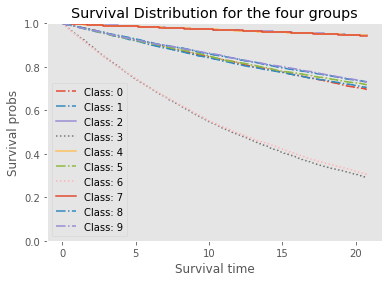

In [23]:
#Vissualization of the KM survival probabilities with respect to the 4 risks.
#We need to see survival distributions per specific risk. We stratify the data according to the risk groups:
plt.style.use('ggplot')
styles = ('-','-.','--',':')
for row in assignment.itertuples():
  mask = y_train == row.Index
  x_coord, y_coord = kaplan_meier_estimator(events_train[mask], time_train[mask])
  ls = styles[row.risk_groups]
  plt.step(x_coord, y_coord, where = 'post',label = f"Class: {row.Index}", linestyle = ls)
plt.ylim(0,1)
plt.ylabel('Survival probs')
plt.xlabel('Survival time')
plt.grid()
plt.legend()
plt.title('Survival Distribution for the four groups')




In [24]:
#We see group 7 has the highest survival as we expected since the risk scores are minimum

In [25]:
#Evaluation of the model is based on corncordance index. This is the degree of how well the 
#observed ordered survival times matches with the ordered predicted risk scores:
#We can obtain this score by assuming the simulated risk-scores above before training our model:

In [26]:
c_index = concordance_index_censored(events_eval, time_eval,risk_scores[y_train.shape[0]:])
print(f"with the actual-simulated risk scores, the concordance index using evaluation set is: {c_index[0]:.4f}")

with the actual-simulated risk scores, the concordance index using evaluation set is: 0.7262


In [27]:
#The perfect score is 1.0 and we've supposed to get 1.0 since we applied on actual data (risk score)
#Due to variation caused by randomly simulated risk scores which are not deterministic. Thus, any model 
#We fit using the above data will not surpass the c-index of 0.7262 (our upper limit inplace of 1.0)

In [28]:
#We can train CPH model by maximizing the partial log-likelihood function (minimizing the negative partial)
#Log-likelihood function. The challenge involved is the computation of the risk set (Those individuals)
#who still alive/have'nt developed an event yet. To use the min-batches we have to be carefull about the
#batch sizes to avoid vanishing of the loss function in case the entire batch is censored.

In [29]:
#We compute the summation of the risk set (denominator of likelihood fn) by using square matrix of 
#indicator function (event/censored) and the exponent part of the predictors. Rows-wise summation will
#lead to risk set for a particular sample/individual.

In [30]:
#We define a function that create a mask for computing risk set for each sample
#This function takes in the survival time (np-array) and return a square matrix of booleans (mask)
def riskset_sum(surv_time: np.ndarray)->np.ndarray:
  assert surv_time.ndim == 1 #The input argument is of shape (sample_size,) which is a one dimensional array
  o = np.argsort(-surv_time, kind = 'mergesort') #sort the survival time in descending order
  sample_size = len(surv_time) #get the total amount of samples
  mask = np.zeros(shape = (sample_size, sample_size), type = np.bool_) #create a boolian square matrix to be used as mask
  for i, j in enumerate(o):
    ti = surv_time[j]
    k = i
    while k < sample_size and ti == surv_time[o[k]]:
      k+=1
    mask[j, o[:k]] = True #compute the mask (help to obtain the risk set)
  return mask


In [31]:
#We now compute the risk-set per batches using the mnist data (images):

In [33]:
class RiskSetCom:
  def __init__(self, img: np.ndarray, suvr_time: np.ndarray, event: np.ndarray,epochs: int = 1,batch_size: int = 64, drop_last: bool = False, shuffle: bool = False, seed: int = 11)->None:
    if img.ndim == 3: #(Height, Width, Channels)
      img = img[..., np.newaxis] #similar to tf.expand_dims (add a new axis)
      self.img = img
      self.suvr_time = suvr_time
      self.event = event
      self.batch_size = batch_size
      self.epochs = epochs
      self.drop_last = drop_last
      self.shuffle = shuffle
      self.seed = seed
    
  def sample_size(self)-> int:
    return self.img.shape[0] #This return the total number of samples
  
  def steps_per_epochs(self)->int:
    return (np.floor(self.sample_size()/self.batch_size))
  
  def mini_batch_get(self, index: np.ndarray)->Tuple[np.ndarray, Dict[str, np.ndarray]]:
    ''' this method computes the risk set for a specified mini-batch'''
    imgs = self.img[index]
    surv_time = self.surv_time[index]
    event = self.event[index]
    labels = {
        'label_event': event.astype(np.int32),
        'label_time': event.astype(np.float32),
        'label_risk_set': riskset_sum(surv_time) # get the mini-batch mask
    }
    return imgs, labels
  
  def iterable_data(self)->Iterable[Tuple[np.ndarray, Dict[str, np.ndarray]]]:
    '''Generate one batch at a time (same as tf.data.Dataset.from_tensor_slices())'''
    idx = np.arrange(self.sample_size())
    rnd = np.random.RandomState(seed = self.seed)
    #Iterate over the epoch
    for _ in range(self.epochs):
      if self.shuffle:
        rnd.shuffle(idx)
        #Iterate over steps
      for batch in range(steps_per_epochs()):
          start = batch * self.batch_size
          idx_batch = idx[start:(start + self.batch_size)]
          yield self.mini_batch_get(idx_batch)
      if not self.drop_last:
        start = self.steps_per_epochs() * self.batch_size 
        idx_batch = idx[start:]
        yield self.steps_per_epochs(idx_batch)

  def get_shape(self)->Tuple[tf.TensorShape, Dict[str, tf.TensorShape]]:
    '''obtain the shapes of the training data constructed by iterable_data() fn above'''
    batch_size = self.batch_size if self.drop_last else None
    height, width, channels = self.img.shape[1:]
    imgs = tf.TensorShape([batch_size, height, width, channels]) #Tf dataset
    labels = {k: tf.TensorShape((batch_size,))
    for k in ('labe_event', 'label_time')}
    labels['label_risk_set'] = tf.TensorShape((batch_size, batch_size))
    return imgs, labels
  
  def get_dtype(self)->Tuple[tf.DType, Dict[str, tf.DType]]:
    ''' This function convert the data into tensorflow datatype'''
    labels = {'label_event': tf.int32,
              'label_time': tf.float32,
              'label_riskset': tf.bool}
    return tf.flot32, labels

  def make_dfm(self)->tf.data.Dataset:
    '''construct a tensorflow dataframe'''
    dt = tf.data.Dataset.from_generator(self.iterable_data(), self.get_shape(),self.get_dtype())
    return dt
  
  def __call__(self)->Tuple[tf.Tensor, Dict[str, tf.Tensor]]:
    dfm = self.make_dfm()
    x_next, y_next = dfm.make_one_short_iterator().get_next()
    return x_next, y_next
  
#We have to normalize the risk scores to reduce variation across the groups
def normalization(x:tf.Tensor)->tf.Tensor:
  '''if the risk score is negative, we reverse the sign to possitive and thus zero is the min-value'''
  min_x = tf.reduce_min(axis = 0)
  c = tf.zeros_like(min_x)
  norm_v = tf.where(min_x < 0, -min_x, c)
  return x + norm

#We compute logsum accross axis for entries where values are true (non-censored data points)
def mask_logsummation(risk_scores: tf.Tensor, mask: tf.Tensor, axis:int = 0, keepdims: Optional[bool] = None)->tf.Tensor:
  risk_scores.get_shape().assert_same_rank(mask.get_shape())
  with tf.name_scope('mask_logsummation', values = [risk_scores, mask]):
    mask_f = tf.cast(mask, risk_scores.dtype)
    risk_scores_masked = tf.multiply(risk_scores, mask_f)
    max_value = tf.reduce_max(risk_scores_masked, axis = axis, keepdims = True)
    risk_scores_adjusted = risk_scores_masked - max_value #Adjust the risk scores by substracting the maximum value
    mask_exp = tf.mutiply(tf.exp(risk_scores_adjusted), mask_f) #compute the product in the exponent
    sum_exp = tf.reduce_sum(mask_exp, axis = axis, keepdims = True) #Compute the summation
    output = max_value + tf.log(sum_exp)#compute the summation of the max-value and the log-exp
    if not keepdims:
      output = tf.squeeze(output, axis = axis)
  return output

  

In [34]:
#The loss function( CPH-Loss Function)